Following Annotated Diffusion (https://huggingface.co/blog/annotated-diffusion)

In [1]:
import math
import torch
import requests

from torch import nn, einsum
from torch.nn import functional as F
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from PIL import Image

import utils

/home/mircea/work/mc_100_days/hf_vision/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


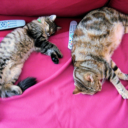

In [2]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
x_start = utils.to_tensor_transform(image).unsqueeze(0)
utils.reverse_tensor_transform(x_start.squeeze()).show()

In [ ]:
timesteps = 300

betas = utils.linear_beta_schedule(timesteps=timesteps)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
# needed in p_sample
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)


# calculations for forward diffusion q(x_t | x_{t-1})
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

# calculate for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)